##  Objective: train a simple deep learning model to predict the lineage of a cell from it's position, size and time value. 

In [ ]:
## data science essentials 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## deep learning utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Extra tools for smoothening curves,etc
from imblearn.over_sampling import RandomOverSampler
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from sklearn.preprocessing import MinMaxScaler

## notebook display
from IPython.display import clear_output
from tqdm.notebook import tqdm

## path to load data from 
ROOT = "/content/drive/My Drive/"

## Loading up the training data 
* `x,y` specify the position of the cell, while `t` gives the time.
* `cell` is the full name of the cell, while `compact_cellname` is a shortened version which only tells us about it's lineage.

In [19]:
df = pd.read_csv(ROOT+ "data/unc_training_data.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8984 entries, 0 to 8983
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cell              8984 non-null   object 
 1   time              8984 non-null   int64  
 2   x                 8984 non-null   int64  
 3   y                 8984 non-null   int64  
 4   z                 8984 non-null   float64
 5   size              8984 non-null   int64  
 6   compact_cellname  8984 non-null   object 
 7   label             8984 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 561.6+ KB
None


In [20]:
labels = df.compact_cellname.unique()
labels

array(['AB', 'EM', 'MS', 'E', 'Ea', 'Ep', 'P2', 'C', 'Ca', 'Cp', 'P3',
       'D', 'Da', 'Dp', 'P4', 'Z2', 'Z3'], dtype=object)

### Viewing the new labels

In [21]:
df.head(4)

,cell,time,x,y,z,size,compact_cellname,label
0,ABa,1,280,277,15.0,60,AB,0
1,ABa,2,283,280,17.2,66,AB,0
2,ABa,3,263,282,18.3,60,AB,0
3,ABa,4,245,282,18.3,66,AB,0



## Visualising the categorical distribution of the data 
* As it can be seen below, the data is unbalanced. With two of the classes taking most of the data. 

17


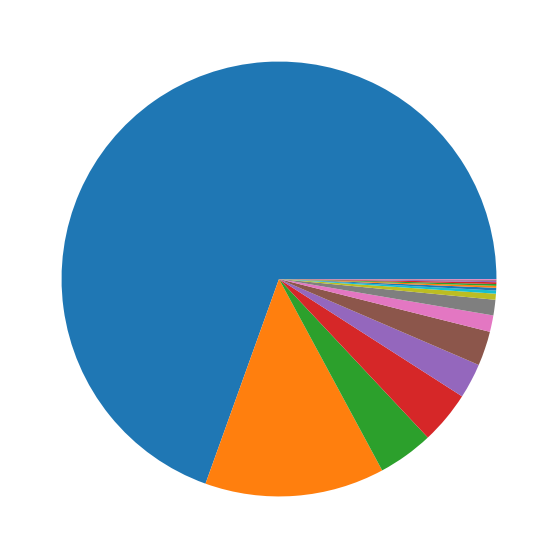

In [32]:
labels = df.compact_cellname.unique()

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['text.color'] = 'white'
plt.rcParams['font.size'] = 20.0


x_vals = df[["x", "y", "z", "time", "size"]]
y_vals = df["label"]
print(len(y_vals.value_counts().values))

plt.pie(y_vals.value_counts().values, labels = labels)
plt.show()

## Fixing the data imbalance with `RandomOverSampler()`

In [33]:
oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(x_vals, y_vals)

# plt.pie(y_over.value_counts())
# plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [34]:
x_vals = x_over
y_vals = y_over

print(x_vals.shape)
print(y_vals.shape)

(106165, 5)
(106165,)


In [0]:
x_train_tensor = torch.from_numpy(x_vals).float()
y_train_tensor = torch.from_numpy(y_vals).float()
full_dataset = TensorDataset(x_train_tensor, y_train_tensor)    ## make compatible with DataLoader 

## Train test split

In [36]:
train_size = int(0.9 * len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=150, shuffle=True, num_workers = 8)

val_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle = True, num_workers = 8)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")


637 batches 
11  batches 


## The model architecture
* Dropout layers were used to avoid overfitting. `p = 0.2` means there is a probability of 0.2 that input will "drop out" and skip to the next layer.
* In order to train the model in the GPU, `.cuda()` was used to move the model into the GPU. 

In [37]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)

        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))

        x = F.relu(self.fc5(x))

        return (self.fc6(x))
    
model = Model()
print(model)
model = model.cuda()

Model(
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=5, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
)


## Reducing the learning rate when the loss curve plateaus
* `factor = 0.7` means the the new learning rate would be `new_lr = 0.7 * current_lr`
* `patience = 6` means the function would wait for 6 epochs with no imporvement in loss before reducing the learning rate. 
* For a more  detailed reference, check the [docs](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau)

In [0]:
optimizer = optim.Adam(model.parameters(), lr = 0.001) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=6, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
losses = []
val_losses = []
accuracies = []
train_accuracies = []
learning_rates = []

### Learning rate visualization
 `get_lr` returns the current learning rate of a model while training, while `show_lr()` plots them.  

In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

## The training loop
* `.cuda()` moves the tensors to the GPU for faster training 
*  `calculate_accuracy_on_validation_set()` returns the classicication accuracy of the model on a given `DataLoader()` (dataset). 
* `train_step()` defines one iterative training step for a given batch which involves loss calculation and backpropagation. 
* `train()` trains the model for n epochs and displays the training metrics in the process. 

In [0]:
def calculate_accuracy_on_validation_set(val_loader, model):

    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for batch in val_loader:
            x_val, y_val = batch

            x_val = x_val.cuda()
            y_val = y_val.cuda()
            pred = model(x_val)  # pred()
            scores = ([i.item() for i in (torch.eq(torch.argmax(pred,dim = 1).float(), y_val))])
            for m in scores:
                total+= 1 
                if m == True:
                    correct +=1 
        acc = (correct/total)*100
        return acc
    
    
def train_step(x, y):
    x = x.cuda()
    y = y.cuda()
    optimizer.zero_grad()
    pred = model(x)
    loss = F.cross_entropy(pred, y.long())
    loss.backward()
    optimizer.step()
    return loss.cpu().item()

def train(epochs):
    
    for m in range (epochs):
        clear_output()

        show_lr(learning_rates)
        plt.plot(accuracies, label = "test")
        plt.plot(train_accuracies, label = "train")
        plt.xlabel("epochs", fontsize = 15)
        plt.ylabel("accuracy", fontsize=15)
        plt.grid()
        plt.legend()
        plt.show()



        print ("epoch ", m+1, " out of ", epochs )
        model.train()
        for x_batch, y_batch in tqdm(train_loader):


                loss = train_step(x_batch, y_batch)
                losses.append(loss)

        with torch.no_grad():
                model.eval()

                for x_val, y_val in tqdm(val_loader):

                    x_val = x_val.cuda()
                    y_val = y_val.cuda()

                    yhat = model(x_val)  # pred 
                    val_loss = F.cross_entropy(yhat, y_val.long())

                    val_losses.append(val_loss.item())  ## metrics 
        scheduler.step(1.)   ## lr decay caller 
        learning_rates.append(get_lr(optimizer))
        accuracies.append(calculate_accuracy_on_validation_set(val_loader, model))
        train_accuracies.append(calculate_accuracy_on_validation_set(train_loader, model))

    clear_output()

    show_lr(learning_rates)
    plt.plot(accuracies, label = "test")
    plt.plot(train_accuracies, label = "train")
    plt.xlabel("epochs", fontsize = 15)
    plt.ylabel("accuracy", fontsize=15)
    plt.grid()
    plt.legend()
    plt.show()
    print ("Final accuracy = ", accuracies[-1], " %")

### It can be seen below how the learning rate decreases whenever the accuracy plateaus.

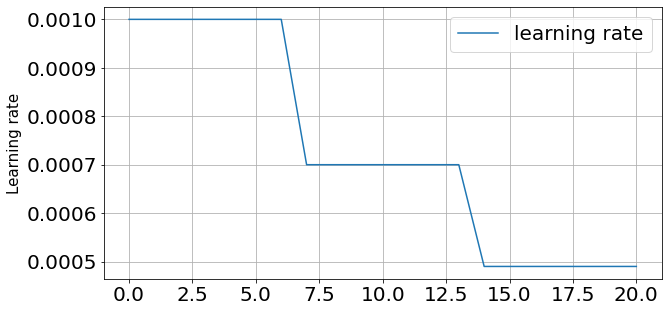

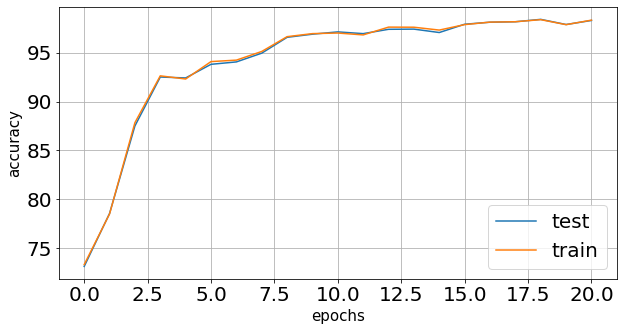

Final accuracy =  98.28576810775172  %


In [43]:
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.figsize'] = 10, 5
train(20)

### Saving the model

In [0]:
torch.save(model.state_dict(), ROOT + "models/" + "epic_dataset_model.pt")